# Intelligent Systems - Assignment 1

- Author: Tim Hrovat
- Student no.: 63230112
- Date: 30. 11. 2025

## Introduction

This seminar presents a comprehensive implementation of genetic algorithms for solving graph pathfinding problems of increasing complexity. The assignment explores the application of evolutionary computation techniques to find optimal paths in directed graphs, progressing from simple two-node pathfinding to complex multi-agent coordination scenarios.

## Setup and imports

This section imports the essential libraries for running my solutions. The implementation utilizes the PyGAD library for genetic algorithm operations and NetworkX for graph representation. Fixed random seeds ensure reproducible results across multiple algorithm runs which enable reliable outputs.

In [107]:
# import sys
# !{sys.executable} -m pip install pygad networkx

import pygad
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from typing import List, Tuple

random.seed(42)
np.random.seed(42)

## Graph representation and input

The GraphManager class handles graph I/O operations and provides baseline comparison functionality with the dijkstra algorithm.

In [108]:
class GraphManager:
    def __init__(self):
        self.graph = None
        self.num_nodes = 0

    def read(self, filename: str) -> nx.DiGraph:
        self.graph = nx.DiGraph()

        with open(filename, 'r') as file:
            lines = file.readlines()
            self.num_nodes = int(lines[0].strip())

            for i in range(1, self.num_nodes + 1):
                self.graph.add_node(i)

            for line in lines[1:]:
                if line.strip():
                    parts = line.strip().split()
                    if len(parts) >= 3:
                        node_a, node_b, weight = int(parts[0]), int(
                            parts[1]), float(parts[2])
                        self.graph.add_edge(node_a, node_b, weight=weight)

        return self.graph
        
    def display(self, title: str = "Graph Visualization") -> None:
        plt.figure(figsize=(12, 8))

        pos = nx.spring_layout(self.graph, seed=42)

        nx.draw_networkx_nodes(self.graph, pos, node_color='lightblue',
                              node_size=500, alpha=0.9)
        nx.draw_networkx_edges(self.graph, pos, edge_color='gray',
                              arrows=True, arrowsize=20, alpha=0.7)
        nx.draw_networkx_labels(self.graph, pos, font_size=12, font_weight='bold')

        edge_labels = nx.get_edge_attributes(self.graph, 'weight')
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels, font_size=10)

        plt.title(title, fontsize=16, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def dijkstra(self, start: int, end: int) -> Tuple[List[int], float]:
        try:
            path = nx.shortest_path(self.graph, start, end, weight='weight')
            distance = nx.shortest_path_length(
                self.graph, start, end, weight='weight')
            return path, distance
        except nx.NetworkXNoPath:
            return [], float('inf')

I defined several directed graphs in the `./graphs` directory but for the sake of simplicity I will focus primarily on the mid sized graph which looks like this:

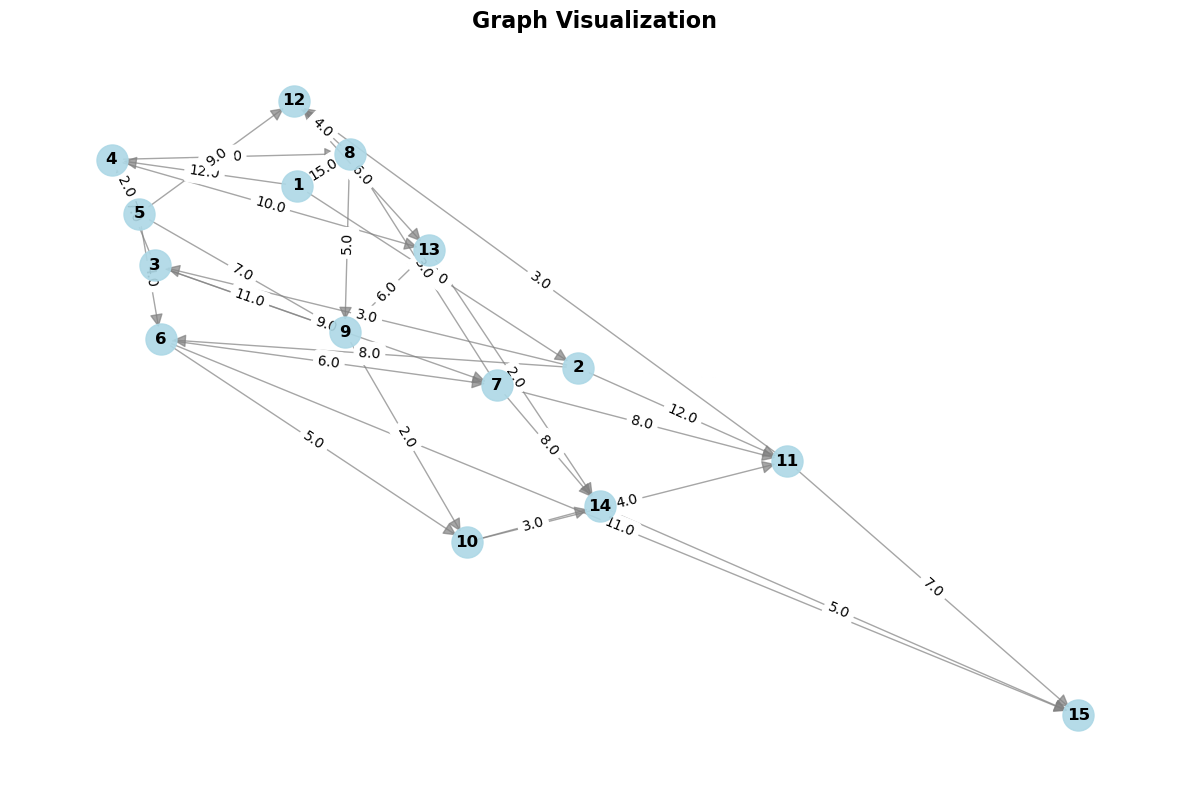

In [109]:
# This constant will be used to load the graph in all tasks
GRAPH_FILE='graphs/medium_graph.txt'

def graph_display():
    graph_manager = GraphManager()
    graph_manager.read(GRAPH_FILE)
    graph_manager.display()

graph_display()

## Task 1: Shortest Path Between Two Nodes

### Implementation

I encapsulated my solution to the 1st task inside a Task1GA class. The implementation details are described via inline comments inside the code section.

In [110]:
class Task1GA:
    def __init__(self, graph_manager, start_node: int, end_node: int):
        self.graph_manager = graph_manager
        self.graph = graph_manager.graph
        self.start_node = start_node
        self.end_node = end_node
        self.nodes = list(self.graph.nodes())
        self.max_path_length = min(len(self.nodes) * 2, 20)
        self.gene_space = self.nodes + [-1]
        self.best_solution = None
        self.best_fitness = float('-inf')
        self.fitness_history = []

    def get_neighbors(self, node: int) -> List[int]:
        return list(self.graph.neighbors(node))

    def decode_chromosome(self, chromosome: List[int]) -> List[int]:
        # Remove -1 padding
        path = [gene for gene in chromosome if gene != -1]
        
        # Remove duplicates while preserving order
        seen = set()
        unique_path = []
        for node in path:
            if node not in seen:
                seen.add(node)
                unique_path.append(node)
        
        path = unique_path
        
        # Ensure path starts with start_node
        if not path or path[0] != self.start_node:
            path = [self.start_node] + [node for node in path if node != self.start_node]
        
        # Ensure path ends with end_node
        if not path or path[-1] != self.end_node:
            if self.end_node in path:
                path = [node for node in path if node != self.end_node] + [self.end_node]
            else:
                path.append(self.end_node)
        
        return path

    def calculate_path_distance(self, path: List[int]) -> float:
        if len(path) < 2:
            return float('inf')

        total_distance = 0
        for i in range(len(path) - 1):
            if self.graph.has_edge(path[i], path[i + 1]):
                total_distance += self.graph[path[i]][path[i + 1]]['weight']
            else:
                return float('inf')

        return total_distance

    def fitness_function(self, ga_instance, solution, solution_idx):
        path = self.decode_chromosome(solution)
        distance = self.calculate_path_distance(path)
        
        if distance == float('inf'):
            return 0.001
        
        # Fitness is inverse of distance (higher fitness = shorter distance)
        # Add small penalty for path length to prefer simpler paths
        length_penalty = len(path) * 0.1
        fitness = 10000.0 / (distance + length_penalty + 1)
        
        # Track best solution
        if fitness > self.best_fitness:
            self.best_fitness = fitness
            self.best_solution = path.copy()
        
        return fitness

    def generate_initial_population(self, population_size: int) -> List[List[int]]:
        population = []

        for _ in range(population_size):
            chromosome = [self.start_node]
            current = self.start_node
            max_steps = min(10, len(self.nodes))
            
            for _ in range(max_steps):
                if current == self.end_node:
                    break
                
                neighbors = self.get_neighbors(current)
                if neighbors:
                    # Prefer moving towards end_node occasionally
                    if random.random() < 0.3 and self.end_node in neighbors:
                        next_node = self.end_node
                    else:
                        next_node = random.choice(neighbors)
                    
                    if next_node not in chromosome:
                        chromosome.append(next_node)
                        current = next_node
                else:
                    break
            
            # Ensure we end at end_node
            if chromosome[-1] != self.end_node:
                chromosome.append(self.end_node)
            
            # Pad with -1
            while len(chromosome) < self.max_path_length:
                chromosome.append(-1)
            
            chromosome = chromosome[:self.max_path_length]
            population.append(chromosome)

        return population

    def mutation(self, offspring, ga_instance):
        for chromosome_idx in range(offspring.shape[0]):
            if random.random() >= ga_instance.mutation_probability:
                continue

            path = self.decode_chromosome(offspring[chromosome_idx])
            
            if len(path) < 3:
                continue
            
            mutation_type = random.choice(['remove_node', 'insert_neighbor', 'swap_nodes'])

            if mutation_type == 'remove_node' and len(path) > 2:
                # Remove a random node
                idx = random.randint(1, len(path) - 2)
                path.pop(idx)
            
            elif mutation_type == 'insert_neighbor' and len(path) < self.max_path_length - 1:
                # Insert a neighbor of an existing node
                idx = random.randint(0, len(path) - 2)
                neighbors = self.get_neighbors(path[idx])
                if neighbors:
                    new_node = random.choice(neighbors)
                    if new_node not in path:
                        path.insert(idx + 1, new_node)
            
            elif mutation_type == 'swap_nodes' and len(path) > 3:
                # Swap two nodes
                idx = random.randint(1, len(path) - 3)
                path[idx], path[idx + 1] = path[idx + 1], path[idx]
            
            new_chromosome = path + [-1] * (self.max_path_length - len(path))
            offspring[chromosome_idx] = np.array(new_chromosome[:self.max_path_length])

        return offspring

    def crossover(self, parents, offspring_size, ga_instance):
        offspring = []

        for _ in range(offspring_size[0]):
            parent1_idx = random.randint(0, parents.shape[0] - 1)
            parent2_idx = random.randint(0, parents.shape[0] - 1)

            path1 = self.decode_chromosome(parents[parent1_idx])
            path2 = self.decode_chromosome(parents[parent2_idx])

            # Two-point crossover with path segments
            if len(path1) > 2 and len(path2) > 2:
                cut1 = random.randint(1, len(path1) - 1)
                cut2 = random.randint(1, len(path2) - 1)
                
                child = [self.start_node]
                
                # Add some nodes from parent1
                for node in path1[1:cut1]:
                    if node not in child and node != self.end_node:
                        child.append(node)
                
                # Add some nodes from parent2
                for node in path2[1:cut2]:
                    if node not in child and node != self.end_node:
                        child.append(node)
                
                child.append(self.end_node)
            else:
                child = path1.copy()

            # Pad with -1
            child_chromosome = child + [-1] * (self.max_path_length - len(child))
            offspring.append(child_chromosome[:self.max_path_length])

        return np.array(offspring)

    def on_generation(self, ga_instance):
        best_fitness = ga_instance.best_solution()[1]
        self.fitness_history.append(best_fitness)
        
    def run(self, population_size: int = 100, num_generations: int = 150,
            mutation_probability: float = 0.2, num_parents_mating: int = 20):
        print(f"Running GA: {self.start_node} → {self.end_node}")

        initial_population = self.generate_initial_population(population_size)

        start_time = time.time()

        ga_instance = pygad.GA(
            num_generations=num_generations,
            num_parents_mating=num_parents_mating,
            fitness_func=self.fitness_function,
            initial_population=initial_population,
            gene_space=self.gene_space,
            mutation_probability=mutation_probability,
            crossover_type=self.crossover,
            mutation_type=self.mutation,
            parent_selection_type='rws',
            keep_parents=2,  # Keep best parents
            on_generation=self.on_generation,
            suppress_warnings=True
        )

        ga_instance.run()
        execution_time = time.time() - start_time

        solution, solution_fitness, _ = ga_instance.best_solution()
        best_path = self.decode_chromosome(solution)
        best_distance = self.calculate_path_distance(best_path)

        dijkstra_path, dijkstra_distance = self.graph_manager.dijkstra(
            self.start_node, self.end_node)

        print(f"\nResults:")
        print(f"GA Path: {best_path}, Distance: {best_distance}")
        print(f"Dijkstra Path: {dijkstra_path}, Distance: {dijkstra_distance}")
        print(f"Execution Time: {execution_time:.2f}s")
        
        if best_distance != float('inf') and dijkstra_distance != float('inf'):
            optimality = (best_distance / dijkstra_distance) * 100
            print(f"Optimality: {optimality:.2f}%")

        plt.figure(figsize=(10, 6))
        plt.plot(self.fitness_history, linewidth=2)
        plt.title('Fitness Convergence')
        plt.xlabel('Generation')
        plt.ylabel('Best Fitness')
        plt.grid(True)
        plt.show()

        return {
            'best_path': best_path,
            'best_distance': best_distance,
            'dijkstra_path': dijkstra_path,
            'dijkstra_distance': dijkstra_distance,
            'fitness_history': self.fitness_history,
            'execution_time': execution_time
        }

### Test

Running GA: 8 → 13

Results:
GA Path: [np.float64(8.0), np.float64(12.0), np.float64(13.0)], Distance: 10.0
Dijkstra Path: [8, 12, 13], Distance: 10.0
Execution Time: 0.03s
Optimality: 100.00%


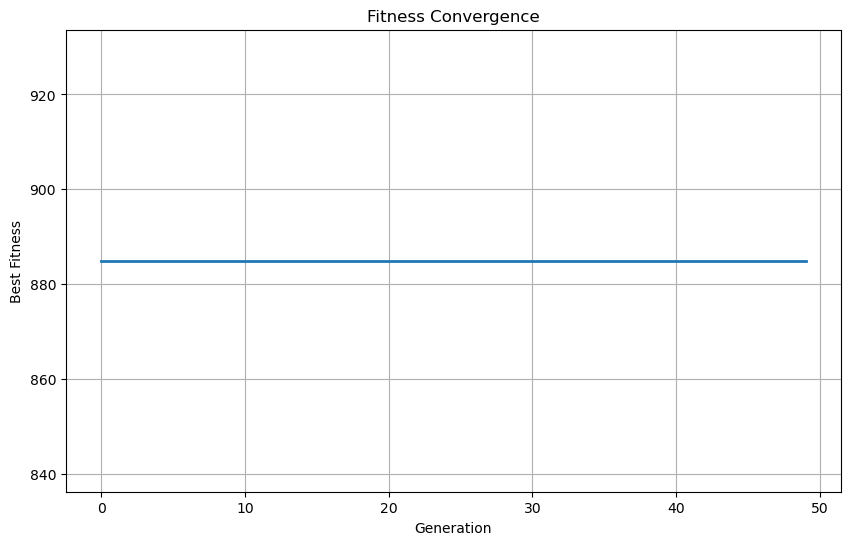

In [111]:
def task_1_test():
    graph_manager = GraphManager()
    graph_manager.read(GRAPH_FILE)

    ga_solver = Task1GA(graph_manager, start_node=8, end_node=13)

    result = ga_solver.run(
        population_size=30,
        num_generations=50,
        mutation_probability=0.2
    )

task_1_test()

## Task 2 - Shortest path between multiple nodes

### Implementation

I encapsulated my solution to the 2nd task inside a Task2GA class which is based on the code from 1st task with some modifications which are higlighted via "CHANGE" comments inside the code block.

In [116]:
class Task2GA:
    """
    KEY CHANGES FROM TASK1:
    1. Accepts a LIST of target nodes instead of just start/end
    2. Must visit all target nodes IN ORDER
    3. Allows revisiting nodes (for backtracking)
    4. Modified fitness function with severe penalties for constraint violations
    5. Enhanced crossover to preserve target node ordering
    6. Smarter mutation that respects target node constraints
    7. Intelligent initial population that builds paths segment-by-segment
    """
    
    def __init__(self, graph_manager, target_nodes: List[int]):
        """
        CHANGE: Instead of start_node and end_node, we now accept target_nodes list
        target_nodes: List of nodes that must be visited in order [A, B, C, ..., N]
        """
        self.graph_manager = graph_manager
        self.graph = graph_manager.graph
        self.target_nodes = target_nodes  # NEW: List of nodes to visit in order
        self.start_node = target_nodes[0]
        self.end_node = target_nodes[-1]
        self.nodes = list(self.graph.nodes())
        
        # CHANGE: Increase max path length since we may need backtracking
        self.max_path_length = min(len(self.nodes) * 3, 30)
        self.gene_space = self.nodes + [-1]
        
        self.best_solution = None
        self.best_fitness = float('-inf')
        self.fitness_history = []

    def get_neighbors(self, node: int) -> List[int]:
        return list(self.graph.neighbors(node))

    def decode_chromosome(self, chromosome: List[int]) -> List[int]:
        """
        CHANGE: Allows duplicate nodes (for backtracking)
        Still removes -1 padding, but doesn't remove duplicates anymore
        """
        # Remove -1 padding
        path = [gene for gene in chromosome if gene != -1]
        
        # NEW: Don't remove duplicates - we need them for backtracking!
        # OLD Task1 code removed duplicates here
        
        return path

    def validate_path_targets(self, path: List[int]) -> bool:
        """
        NEW METHOD: Check if path visits all target nodes in correct order
        Returns True if path is valid, False otherwise
        """
        if len(path) < len(self.target_nodes):
            return False
        
        target_idx = 0
        for node in path:
            if target_idx < len(self.target_nodes) and node == self.target_nodes[target_idx]:
                target_idx += 1
        
        return target_idx == len(self.target_nodes)

    def calculate_path_distance(self, path: List[int]) -> float:
        """
        Same as Task1, but now works with paths that may have duplicates
        """
        if len(path) < 2:
            return float('inf')

        total_distance = 0
        for i in range(len(path) - 1):
            if self.graph.has_edge(path[i], path[i + 1]):
                total_distance += self.graph[path[i]][path[i + 1]]['weight']
            else:
                return float('inf')  # Invalid path - no edge exists

        return total_distance

    def fitness_function(self, ga_instance, solution, solution_idx):
        """
        MAJOR CHANGE: Fitness now heavily penalizes paths that don't visit
        all target nodes in order
        """
        path = self.decode_chromosome(solution)
        
        # NEW: Check if path visits all targets in order
        is_valid = self.validate_path_targets(path)
        
        if not is_valid:
            # SEVERE PENALTY for invalid paths
            # Still give some fitness based on how many targets were reached
            target_idx = 0
            for node in path:
                if target_idx < len(self.target_nodes) and node == self.target_nodes[target_idx]:
                    target_idx += 1
            
            # Partial credit: 0.001 to 0.01 based on targets reached
            return 0.001 + (target_idx / len(self.target_nodes)) * 0.009
        
        distance = self.calculate_path_distance(path)
        
        if distance == float('inf'):
            return 0.001
        
        # Valid path: fitness based on distance
        # Smaller length penalty since backtracking may be necessary
        length_penalty = len(path) * 0.05  # Reduced from 0.1 in Task1
        fitness = 10000.0 / (distance + length_penalty + 1)
        
        # Track best solution
        if fitness > self.best_fitness:
            self.best_fitness = fitness
            self.best_solution = path.copy()
        
        return fitness

    def generate_initial_population(self, population_size: int) -> List[List[int]]:
        """
        MAJOR CHANGE: Build paths segment-by-segment between consecutive target nodes
        This ensures the initial population respects target ordering
        """
        population = []

        for _ in range(population_size):
            chromosome = []
            
            # NEW: Build path by connecting each consecutive pair of target nodes
            for i in range(len(self.target_nodes) - 1):
                start = self.target_nodes[i]
                end = self.target_nodes[i + 1]
                
                # Try to find a path from start to end using random walk
                segment = [start]
                current = start
                max_steps = min(8, len(self.nodes))
                
                for step in range(max_steps):
                    if current == end:
                        break
                    
                    neighbors = self.get_neighbors(current)
                    if neighbors:
                        # Higher probability to move toward target
                        if random.random() < 0.4 and end in neighbors:
                            next_node = end
                        else:
                            next_node = random.choice(neighbors)
                        
                        segment.append(next_node)
                        current = next_node
                    else:
                        break
                
                # Ensure segment ends at target
                if segment[-1] != end:
                    segment.append(end)
                
                # Add segment to chromosome (skip first node if not first segment to avoid duplication)
                if i == 0:
                    chromosome.extend(segment)
                else:
                    chromosome.extend(segment[1:])
            
            # Pad with -1
            while len(chromosome) < self.max_path_length:
                chromosome.append(-1)
            
            chromosome = chromosome[:self.max_path_length]
            population.append(chromosome)

        return population

    def mutation(self, offspring, ga_instance):
        """
        ENHANCED MUTATION: Preserves target node ordering
        Only mutates segments BETWEEN target nodes
        """
        for chromosome_idx in range(offspring.shape[0]):
            if random.random() >= ga_instance.mutation_probability:
                continue

            path = self.decode_chromosome(offspring[chromosome_idx])
            
            if len(path) < 3:
                continue
            
            # NEW: Find positions of target nodes in path
            target_positions = []
            for i, node in enumerate(path):
                if node in self.target_nodes:
                    target_positions.append(i)
            
            if len(target_positions) < 2:
                continue
            
            # Choose a random segment between two consecutive target nodes
            segment_idx = random.randint(0, len(target_positions) - 2)
            segment_start = target_positions[segment_idx]
            segment_end = target_positions[segment_idx + 1]
            
            if segment_end - segment_start <= 1:
                continue  # No room to mutate
            
            mutation_type = random.choice(['remove_node', 'insert_neighbor', 'swap_nodes', 'replace_segment'])

            if mutation_type == 'remove_node' and segment_end - segment_start > 1:
                # Remove a node in the segment (not the target nodes themselves)
                idx = random.randint(segment_start + 1, segment_end - 1)
                path.pop(idx)
            
            elif mutation_type == 'insert_neighbor' and len(path) < self.max_path_length - 1:
                # Insert a neighbor between segment boundaries
                idx = random.randint(segment_start, segment_end - 1)
                neighbors = self.get_neighbors(path[idx])
                if neighbors:
                    new_node = random.choice(neighbors)
                    path.insert(idx + 1, new_node)
            
            elif mutation_type == 'swap_nodes' and segment_end - segment_start > 2:
                # Swap two nodes within the segment
                idx1 = random.randint(segment_start + 1, segment_end - 2)
                idx2 = idx1 + 1
                path[idx1], path[idx2] = path[idx2], path[idx1]
            
            new_chromosome = path + [-1] * (self.max_path_length - len(path))
            offspring[chromosome_idx] = np.array(new_chromosome[:self.max_path_length])

        return offspring

    def crossover(self, parents, offspring_size, ga_instance):
        """
        ENHANCED CROSSOVER: Preserves target node ordering by crossing over
        segments between target nodes
        """
        offspring = []

        for _ in range(offspring_size[0]):
            parent1_idx = random.randint(0, parents.shape[0] - 1)
            parent2_idx = random.randint(0, parents.shape[0] - 1)

            path1 = self.decode_chromosome(parents[parent1_idx])
            path2 = self.decode_chromosome(parents[parent2_idx])

            # NEW: Find target positions in both parents
            def find_target_positions(path):
                positions = []
                for i, node in enumerate(path):
                    if node in self.target_nodes:
                        positions.append(i)
                return positions
            
            target_pos1 = find_target_positions(path1)
            target_pos2 = find_target_positions(path2)
            
            if len(target_pos1) < 2 or len(target_pos2) < 2:
                # Fallback: use better parent
                child = path1.copy() if len(target_pos1) >= len(target_pos2) else path2.copy()
            else:
                # NEW: Segment-based crossover
                child = []
                
                # For each segment between consecutive targets, randomly choose from parent1 or parent2
                for i in range(len(self.target_nodes) - 1):
                    # Extract segment from random parent
                    if random.random() < 0.5 and i < len(target_pos1) - 1:
                        # Use segment from parent1
                        start_idx = target_pos1[i]
                        end_idx = target_pos1[i + 1]
                        segment = path1[start_idx:end_idx + 1]
                    elif i < len(target_pos2) - 1:
                        # Use segment from parent2
                        start_idx = target_pos2[i]
                        end_idx = target_pos2[i + 1]
                        segment = path2[start_idx:end_idx + 1]
                    else:
                        # Fallback: create simple segment
                        segment = [self.target_nodes[i], self.target_nodes[i + 1]]
                    
                    # Add segment (avoid duplicating target nodes)
                    if i == 0:
                        child.extend(segment)
                    else:
                        child.extend(segment[1:])

            # Pad with -1
            child_chromosome = child + [-1] * (self.max_path_length - len(child))
            offspring.append(child_chromosome[:self.max_path_length])

        return np.array(offspring)

    def on_generation(self, ga_instance):
        """Same as Task1"""
        best_fitness = ga_instance.best_solution()[1]
        self.fitness_history.append(best_fitness)
        
    def run(self, population_size: int = 100, num_generations: int = 200,
            mutation_probability: float = 0.25, num_parents_mating: int = 30):
        """
        CHANGE: Increased default num_generations (200 vs 150) and num_parents_mating (30 vs 20)
        because Task2 is more complex
        """
        print(f"Running GA for multi-node path: {' → '.join(map(str, self.target_nodes))}")

        initial_population = self.generate_initial_population(population_size)

        start_time = time.time()

        ga_instance = pygad.GA(
            num_generations=num_generations,
            num_parents_mating=num_parents_mating,
            fitness_func=self.fitness_function,
            initial_population=initial_population,
            gene_space=self.gene_space,
            mutation_probability=mutation_probability,
            crossover_type=self.crossover,
            mutation_type=self.mutation,
            parent_selection_type='rws',
            keep_parents=3,  # CHANGE: Keep more parents (3 vs 2) for better diversity
            on_generation=self.on_generation,
            suppress_warnings=True
        )

        ga_instance.run()
        execution_time = time.time() - start_time

        solution, solution_fitness, _ = ga_instance.best_solution()
        best_path = self.decode_chromosome(solution)
        best_distance = self.calculate_path_distance(best_path)

        # NEW: Calculate Dijkstra path for comparison (sum of segments)
        dijkstra_total_distance = 0
        dijkstra_full_path = []
        
        for i in range(len(self.target_nodes) - 1):
            seg_path, seg_dist = self.graph_manager.dijkstra(
                self.target_nodes[i], self.target_nodes[i + 1])
            
            if seg_dist == float('inf'):
                dijkstra_total_distance = float('inf')
                break
            
            dijkstra_total_distance += seg_dist
            if i == 0:
                dijkstra_full_path.extend(seg_path)
            else:
                dijkstra_full_path.extend(seg_path[1:])  # Avoid duplicating nodes

        print(f"\nResults:")
        print(f"GA Path: {best_path}")
        print(f"GA Distance: {best_distance}")
        print(f"Dijkstra Combined Path: {dijkstra_full_path}")
        print(f"Dijkstra Distance: {dijkstra_total_distance}")
        print(f"Execution Time: {execution_time:.2f}s")
        
        if best_distance != float('inf') and dijkstra_total_distance != float('inf'):
            optimality = (best_distance / dijkstra_total_distance) * 100
            print(f"Optimality: {optimality:.2f}%")

        plt.figure(figsize=(10, 6))
        plt.plot(self.fitness_history, linewidth=2)
        plt.title('Fitness Convergence - Multi-Node Path')
        plt.xlabel('Generation')
        plt.ylabel('Best Fitness')
        plt.grid(True)
        plt.show()

        return {
            'best_path': best_path,
            'best_distance': best_distance,
            'dijkstra_path': dijkstra_full_path,
            'dijkstra_distance': dijkstra_total_distance,
            'fitness_history': self.fitness_history,
            'execution_time': execution_time,
            'target_nodes': self.target_nodes
        }

### Test

Running GA for multi-node path: 1 → 5 → 13 → 15

Results:
GA Path: [np.float64(1.0), np.float64(4.0), np.float64(5.0), np.float64(9.0), np.float64(13.0), np.float64(14.0), np.float64(15.0)]
GA Distance: 34.0
Dijkstra Combined Path: [1, 4, 5, 9, 13, 14, 15]
Dijkstra Distance: 34.0
Execution Time: 0.04s
Optimality: 100.00%


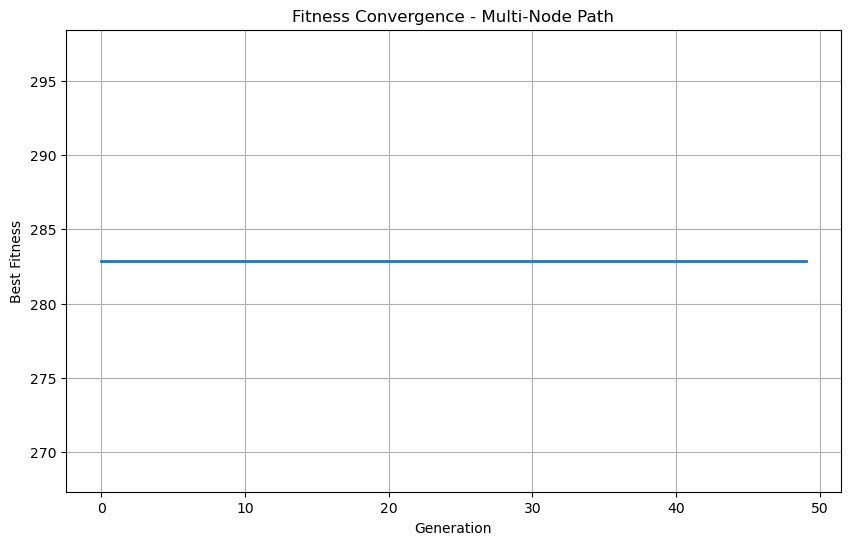

In [113]:
def task_2_test():
    graph_manager = GraphManager()
    graph_manager.read(GRAPH_FILE)

    ga_solver = Task2GA(graph_manager, target_nodes=[1, 5, 13, 15])
    
    result = ga_solver.run(
        population_size=30,
        num_generations=50,
        mutation_probability=0.25
    )

task_2_test()

## Task 3 - Shortest path with multiple agents

### Implementation

In [114]:
class Task3GA:
    """
    Multi-agent pathfinding with collision avoidance.
    
    KEY CHANGES FROM TASK 2:
    1. Multiple agents with different starting positions
    2. Time-based simulation with edge traversal times and waiting
    3. Collision detection for nodes and edges
    4. Chromosome encoding includes wait actions
    5. Fitness based on completion time instead of distance
    """
    
    def __init__(self, graph_manager, target_nodes: List[int], agent_starts: List[int]):
        self.graph_manager = graph_manager
        self.graph = graph_manager.graph
        self.target_nodes = target_nodes
        self.agent_starts = agent_starts  # NEW: Starting position for each agent
        self.num_agents = len(agent_starts)  # NEW: Number of agents
        
        self.nodes = list(self.graph.nodes())
        self.max_path_length = min(len(self.nodes) * 4, 40)  # Longer paths due to waiting
        
        # NEW: Gene space includes WAIT action (-2) in addition to nodes and padding (-1)
        self.gene_space = self.nodes + [-1, -2]  # -1: padding, -2: WAIT
        
        self.best_solution = None
        self.best_fitness = float('-inf')
        self.fitness_history = []
        
        # NEW: Timing constants
        self.WAIT_TIME = 20  # Time to explicitly wait at a node
        self.POST_MOVE_WAIT = 10  # Mandatory wait after moving

    def get_neighbors(self, node: int) -> List[int]:
        return list(self.graph.neighbors(node))

    def decode_chromosome(self, chromosome: np.ndarray) -> List[List[int]]:
        """
        NEW: Decode chromosome into multiple agent paths.
        
        Chromosome structure: [agent1_genes..., agent2_genes..., ...]
        Each agent gets max_path_length genes.
        """
        paths = []
        genes_per_agent = self.max_path_length
        
        for agent_idx in range(self.num_agents):
            start_idx = agent_idx * genes_per_agent
            end_idx = start_idx + genes_per_agent
            agent_genes = chromosome[start_idx:end_idx]
            
            # Decode path: keep nodes and WAIT actions, remove padding
            path = []
            for gene in agent_genes:
                if gene == -1:  # Padding - stop here
                    break
                elif gene == -2:  # WAIT action
                    path.append(-2)
                elif gene in self.nodes:
                    path.append(gene)
            
            paths.append(path)
        
        return paths

    def simulate_agents(self, paths: List[List[int]]) -> Tuple[bool, float, Dict]:
        """
        NEW: Simulate all agents moving through their paths with collision detection.
        
        Returns:
            - is_valid: Whether simulation completed without collisions
            - completion_time: Time when all agents finish
            - simulation_data: Details about the simulation
        """
        # Agent states
        agent_positions = self.agent_starts.copy()
        agent_path_indices = [0] * self.num_agents
        agent_times = [0.0] * self.num_agents
        agent_finished = [False] * self.num_agents
        
        # Track occupied nodes and edges at each time
        max_time = 10000  # Safety limit
        time_step = 0.1  # Simulation granularity
        current_time = 0.0
        
        # Data for collision detection
        node_occupancy = {}  # time -> set of (agent_idx, node)
        edge_occupancy = {}  # time -> set of (agent_idx, from_node, to_node)
        
        while current_time < max_time:
            # Check if all agents finished
            if all(agent_finished):
                break
            
            # Process each agent
            for agent_idx in range(self.num_agents):
                if agent_finished[agent_idx]:
                    continue
                
                # Check if agent can make next move
                if agent_times[agent_idx] > current_time:
                    continue
                
                path = paths[agent_idx]
                path_idx = agent_path_indices[agent_idx]
                
                # Check if agent completed their path
                if path_idx >= len(path):
                    agent_finished[agent_idx] = True
                    continue
                
                current_pos = agent_positions[agent_idx]
                next_action = path[path_idx]
                
                # Handle WAIT action
                if next_action == -2:
                    # Agent waits at current position
                    agent_times[agent_idx] = current_time + self.WAIT_TIME
                    agent_path_indices[agent_idx] += 1
                    
                    # Mark node as occupied during wait
                    for t in np.arange(current_time, current_time + self.WAIT_TIME, time_step):
                        t_key = round(t, 1)
                        if t_key not in node_occupancy:
                            node_occupancy[t_key] = set()
                        node_occupancy[t_key].add((agent_idx, current_pos))
                    
                    continue
                
                # Handle MOVE action
                next_node = next_action
                
                # Validate move
                if next_node not in self.nodes:
                    return False, float('inf'), {}
                
                if next_node == current_pos:
                    # Stay at same node (implicit wait)
                    agent_times[agent_idx] = current_time + self.WAIT_TIME
                    agent_path_indices[agent_idx] += 1
                    
                    for t in np.arange(current_time, current_time + self.WAIT_TIME, time_step):
                        t_key = round(t, 1)
                        if t_key not in node_occupancy:
                            node_occupancy[t_key] = set()
                        node_occupancy[t_key].add((agent_idx, current_pos))
                    
                    continue
                
                # Check if edge exists
                if not self.graph.has_edge(current_pos, next_node):
                    return False, float('inf'), {}
                
                edge_weight = self.graph[current_pos][next_node]['weight']
                move_time = edge_weight
                total_time = move_time + self.POST_MOVE_WAIT
                
                # Check for node collision at destination
                arrival_time = current_time + move_time
                end_time = current_time + total_time
                
                collision = False
                
                # Check if destination node is occupied when we arrive
                for t in np.arange(arrival_time, end_time, time_step):
                    t_key = round(t, 1)
                    if t_key in node_occupancy:
                        for other_agent, other_node in node_occupancy[t_key]:
                            if other_agent != agent_idx and other_node == next_node:
                                collision = True
                                break
                    if collision:
                        break
                
                # Check for edge collision (two agents on same edge)
                for t in np.arange(current_time, arrival_time, time_step):
                    t_key = round(t, 1)
                    if t_key in edge_occupancy:
                        for other_agent, from_n, to_n in edge_occupancy[t_key]:
                            if other_agent != agent_idx:
                                # Check if other agent is on same edge (either direction)
                                if (from_n == current_pos and to_n == next_node) or \
                                   (from_n == next_node and to_n == current_pos):
                                    collision = True
                                    break
                    if collision:
                        break
                
                if collision:
                    # Collision detected - invalid solution
                    return False, float('inf'), {}
                
                # Execute move
                agent_positions[agent_idx] = next_node
                agent_times[agent_idx] = end_time
                agent_path_indices[agent_idx] += 1
                
                # Mark edge as occupied during movement
                for t in np.arange(current_time, arrival_time, time_step):
                    t_key = round(t, 1)
                    if t_key not in edge_occupancy:
                        edge_occupancy[t_key] = set()
                    edge_occupancy[t_key].add((agent_idx, current_pos, next_node))
                
                # Mark destination node as occupied during wait
                for t in np.arange(arrival_time, end_time, time_step):
                    t_key = round(t, 1)
                    if t_key not in node_occupancy:
                        node_occupancy[t_key] = set()
                    node_occupancy[t_key].add((agent_idx, next_node))
            
            current_time += time_step
        
        # Check if simulation completed
        if not all(agent_finished):
            return False, float('inf'), {}
        
        completion_time = max(agent_times)
        
        return True, completion_time, {
            'agent_times': agent_times,
            'final_positions': agent_positions
        }

    def validate_paths(self, paths: List[List[int]]) -> bool:
        """
        NEW: Validate that all agents visit all target nodes in order.
        """
        for agent_idx, path in enumerate(paths):
            # Each agent must start from their designated start
            if not path or (path[0] != self.agent_starts[agent_idx] and path[0] != -2):
                # First action can be WAIT or must be at start position
                if path and path[0] != -2:
                    return False
            
            # Check if path visits all targets in order
            target_idx = 0
            for node in path:
                if node == -2:  # Skip WAIT actions
                    continue
                if target_idx < len(self.target_nodes) and node == self.target_nodes[target_idx]:
                    target_idx += 1
            
            if target_idx < len(self.target_nodes):
                return False
        
        return True

    def fitness_function(self, ga_instance, solution, solution_idx):
        """
        NEW: Fitness based on completion time with collision avoidance.
        """
        paths = self.decode_chromosome(solution)
        
        # Validate basic path structure
        if not self.validate_paths(paths):
            # Penalty based on how many targets were reached
            reached_count = 0
            for path in paths:
                target_idx = 0
                for node in path:
                    if node != -2 and target_idx < len(self.target_nodes) and \
                       node == self.target_nodes[target_idx]:
                        target_idx += 1
                reached_count += target_idx
            
            max_possible = self.num_agents * len(self.target_nodes)
            return 0.001 + (reached_count / max_possible) * 0.009
        
        # Simulate agent movements
        is_valid, completion_time, sim_data = self.simulate_agents(paths)
        
        if not is_valid or completion_time == float('inf'):
            return 0.001
        
        # Fitness: minimize completion time
        # Add small penalty for total path length to prefer direct routes
        total_length = sum(len(path) for path in paths)
        length_penalty = total_length * 0.5
        
        fitness = 100000.0 / (completion_time + length_penalty + 1)
        
        # Track best solution
        if fitness > self.best_fitness:
            self.best_fitness = fitness
            self.best_solution = [p.copy() for p in paths]
        
        return fitness

    def generate_initial_population(self, population_size: int) -> List[np.ndarray]:
        """
        NEW: Generate initial population with multiple agent paths.
        """
        population = []
        
        for _ in range(population_size):
            chromosome = []
            
            for agent_idx in range(self.num_agents):
                agent_path = [self.agent_starts[agent_idx]]
                
                # For each target segment
                for i in range(len(self.target_nodes) - 1):
                    start = self.target_nodes[i] if i == 0 else self.target_nodes[i]
                    end = self.target_nodes[i + 1]
                    
                    # Random walk with occasional waits
                    current = start if not agent_path else agent_path[-1]
                    max_steps = min(10, len(self.nodes))
                    
                    for step in range(max_steps):
                        if current == end:
                            break
                        
                        # Randomly insert WAIT action
                        if random.random() < 0.1 * agent_idx:  # More waits for later agents
                            agent_path.append(-2)
                            continue
                        
                        neighbors = self.get_neighbors(current)
                        if neighbors:
                            if random.random() < 0.4 and end in neighbors:
                                next_node = end
                            else:
                                next_node = random.choice(neighbors)
                            
                            agent_path.append(next_node)
                            current = next_node
                        else:
                            break
                    
                    if agent_path[-1] != end:
                        agent_path.append(end)
                
                # Pad agent path
                while len(agent_path) < self.max_path_length:
                    agent_path.append(-1)
                
                agent_path = agent_path[:self.max_path_length]
                chromosome.extend(agent_path)
            
            population.append(np.array(chromosome))
        
        return population

    def mutation(self, offspring, ga_instance):
        """
        NEW: Mutation that preserves agent structure and can insert/remove WAIT actions.
        """
        genes_per_agent = self.max_path_length
        
        for chromosome_idx in range(offspring.shape[0]):
            if random.random() >= ga_instance.mutation_probability:
                continue
            
            # Mutate random agent
            agent_idx = random.randint(0, self.num_agents - 1)
            start_idx = agent_idx * genes_per_agent
            end_idx = start_idx + genes_per_agent
            
            agent_genes = offspring[chromosome_idx, start_idx:end_idx]
            path = [g for g in agent_genes if g != -1]
            
            if len(path) < 2:
                continue
            
            mutation_type = random.choice([
                'insert_wait', 'remove_wait', 'swap_nodes', 'remove_node', 'insert_neighbor'
            ])
            
            if mutation_type == 'insert_wait' and len(path) < self.max_path_length - 1:
                # Insert WAIT action at random position
                idx = random.randint(0, len(path) - 1)
                path.insert(idx, -2)
            
            elif mutation_type == 'remove_wait':
                # Remove a WAIT action if exists
                wait_indices = [i for i, node in enumerate(path) if node == -2]
                if wait_indices:
                    idx = random.choice(wait_indices)
                    path.pop(idx)
            
            elif mutation_type == 'swap_nodes' and len(path) > 2:
                idx1 = random.randint(1, len(path) - 2)
                idx2 = idx1 + 1
                if path[idx1] != -2 and path[idx2] != -2:
                    path[idx1], path[idx2] = path[idx2], path[idx1]
            
            elif mutation_type == 'remove_node' and len(path) > 2:
                idx = random.randint(1, len(path) - 1)
                if path[idx] != -2:
                    path.pop(idx)
            
            elif mutation_type == 'insert_neighbor' and len(path) < self.max_path_length - 1:
                idx = random.randint(0, len(path) - 1)
                if path[idx] != -2:
                    neighbors = self.get_neighbors(path[idx])
                    if neighbors:
                        new_node = random.choice(neighbors)
                        path.insert(idx + 1, new_node)
            
            # Update chromosome
            new_genes = path + [-1] * (genes_per_agent - len(path))
            offspring[chromosome_idx, start_idx:end_idx] = np.array(new_genes[:genes_per_agent])
        
        return offspring

    def crossover(self, parents, offspring_size, ga_instance):
        """
        NEW: Crossover that exchanges agent paths between parents.
        """
        offspring = []
        genes_per_agent = self.max_path_length
        
        for _ in range(offspring_size[0]):
            parent1_idx = random.randint(0, parents.shape[0] - 1)
            parent2_idx = random.randint(0, parents.shape[0] - 1)
            
            child = []
            
            # For each agent, randomly choose path from parent1 or parent2
            for agent_idx in range(self.num_agents):
                start_idx = agent_idx * genes_per_agent
                end_idx = start_idx + genes_per_agent
                
                if random.random() < 0.5:
                    agent_genes = parents[parent1_idx, start_idx:end_idx]
                else:
                    agent_genes = parents[parent2_idx, start_idx:end_idx]
                
                child.extend(agent_genes)
            
            offspring.append(child)
        
        return np.array(offspring)

    def on_generation(self, ga_instance):
        best_fitness = ga_instance.best_solution()[1]
        self.fitness_history.append(best_fitness)

    def run(self, population_size: int = 150, num_generations: int = 300,
            mutation_probability: float = 0.3, num_parents_mating: int = 50):
        
        print(f"\n{'='*60}")
        print(f"MULTI-AGENT PATHFINDING (Task 3)")
        print(f"{'='*60}")
        print(f"Number of agents: {self.num_agents}")
        print(f"Agent starts: {self.agent_starts}")
        print(f"Target path: {' → '.join(map(str, self.target_nodes))}")
        print(f"{'='*60}\n")
        
        initial_population = self.generate_initial_population(population_size)
        
        start_time = time.time()
        
        ga_instance = pygad.GA(
            num_generations=num_generations,
            num_parents_mating=num_parents_mating,
            fitness_func=self.fitness_function,
            initial_population=initial_population,
            gene_space=self.gene_space,
            mutation_probability=mutation_probability,
            crossover_type=self.crossover,
            mutation_type=self.mutation,
            parent_selection_type='rws',
            keep_parents=5,
            on_generation=self.on_generation,
            suppress_warnings=True
        )
        
        ga_instance.run()
        execution_time = time.time() - start_time
        
        solution, solution_fitness, _ = ga_instance.best_solution()
        best_paths = self.decode_chromosome(solution)
        is_valid, completion_time, sim_data = self.simulate_agents(best_paths)
        
        print(f"\n{'='*60}")
        print(f"RESULTS")
        print(f"{'='*60}")
        
        for agent_idx, path in enumerate(best_paths):
            path_str = ' → '.join([str(n) if n != -2 else 'WAIT' for n in path])
            print(f"Agent {agent_idx + 1}: [{path_str}]")
        
        print(f"\nCompletion Time: {completion_time:.2f} time units")
        print(f"Valid Solution: {is_valid}")
        print(f"Execution Time: {execution_time:.2f}s")
        print(f"{'='*60}\n")
        
        # Plot fitness convergence
        plt.figure(figsize=(10, 6))
        plt.plot(self.fitness_history, linewidth=2, color='purple')
        plt.title('Fitness Convergence - Multi-Agent Pathfinding', fontsize=14, fontweight='bold')
        plt.xlabel('Generation', fontsize=12)
        plt.ylabel('Best Fitness', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return {
            'best_paths': best_paths,
            'completion_time': completion_time,
            'is_valid': is_valid,
            'fitness_history': self.fitness_history,
            'execution_time': execution_time,
            'num_agents': self.num_agents,
            'simulation_data': sim_data
        }

### Test

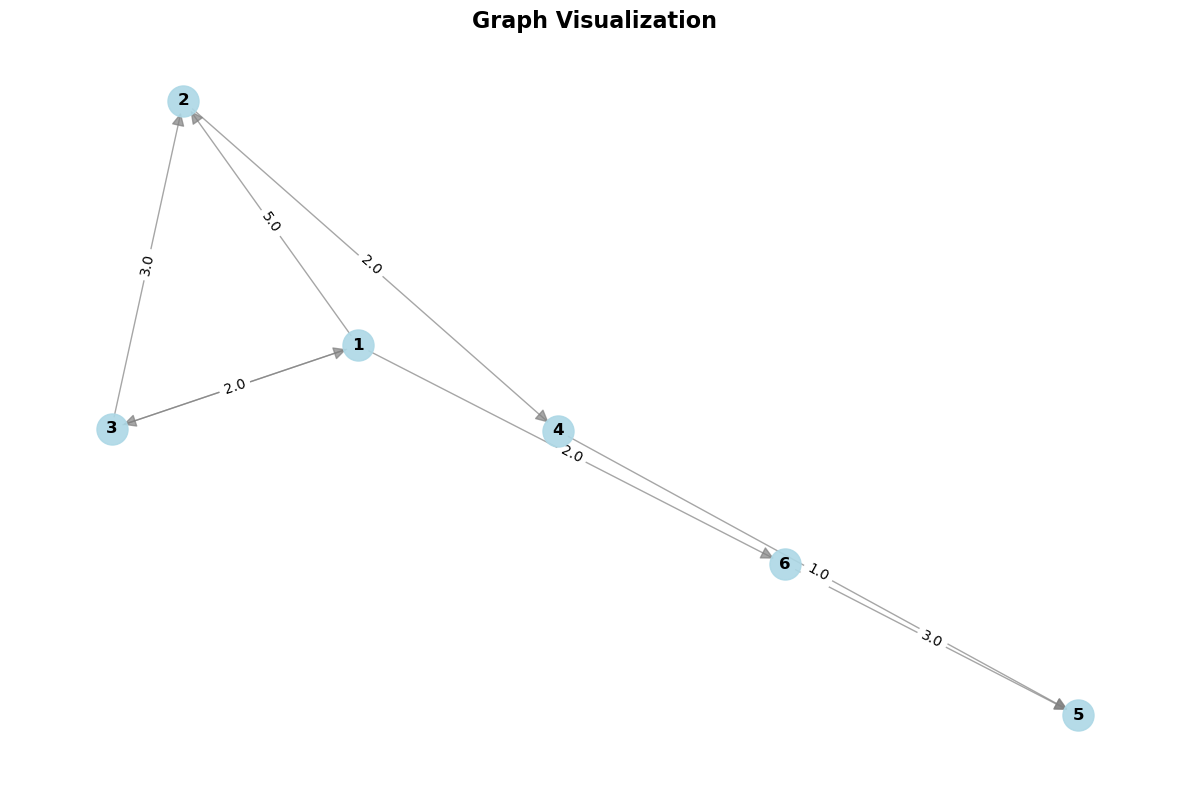


MULTI-AGENT PATHFINDING (Task 3)
Number of agents: 2
Agent starts: [1, 3]
Target path: 2 → 5


RESULTS
Agent 1: [1.0 → 2.0 → 4.0 → 5.0]
Agent 2: [3.0 → 3.0 → 1.0 → 2.0 → 4.0 → 5.0]

Completion Time: 90.10 time units
Valid Solution: True
Execution Time: 7.96s



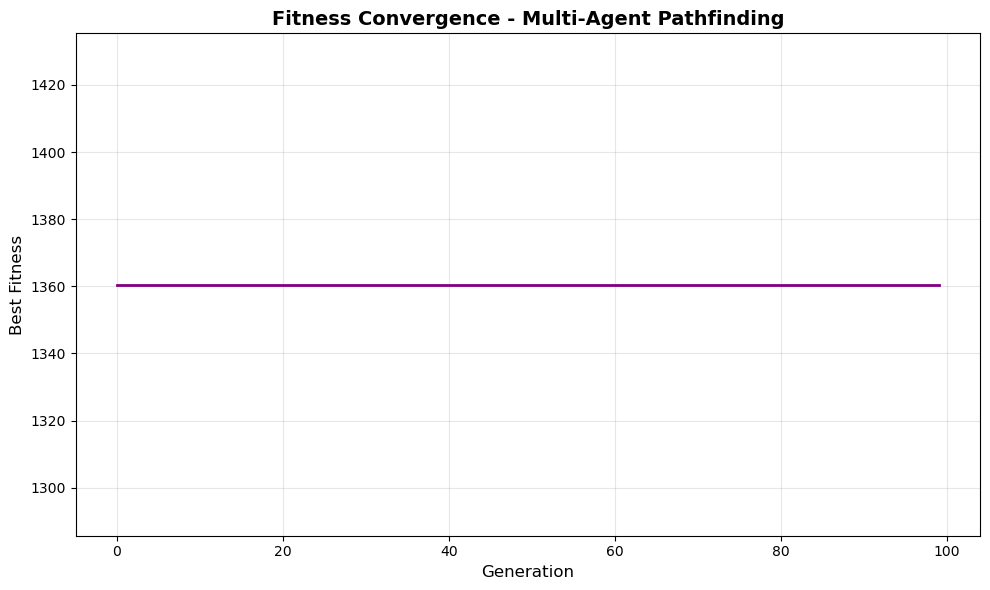

In [115]:
def task_3_test():
    graph_manager = GraphManager()
    graph_manager.read('graphs/task_3_graph.txt')
    graph_manager.display()
    ga_solver = Task3GA(
        graph_manager, 
        target_nodes=[2, 5],
        agent_starts=[1, 3]
    )
    
    result = ga_solver.run(
        population_size=50,
        num_generations=100,
        mutation_probability=0.3
    )

task_3_test()